In [2]:
from qutip import *
from matplotlib import cm
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
from copy import copy

class qutrit:
    def __init__(self,**params) -> None:
        '''
        (w+k)n-k/12(x**4)=wn-k/2*ad*ad*a*a
        '''

        self.params={
        # 'w':[6.8112,4.0755,0],
        # 'yita':[137.4,0.348*0.348/137.4],
        # 'g':[10,0,0],
        'ideal':False,'level':3,
        # qutrit params
        'w':5,          'yita':0.3,
        # drive params
        'wd':[0,0],     'phid':[0,0],   'L':100,
        't_edge':1,     'amp':10,       'sp':[1,0],
        # init
        'rho0':0,       'rho_tar':None,
        }
        self.params.update(params)
        self.params0=copy(self.params)
        self.__setparams(self.params)
    
    def __setparams(self,dic):
        for p in dic:
            setattr(self,p,dic[p])
        
        global n
        n=self.level
        self.tlist=np.linspace(0,self.L,self.TStep)
        if self.rho_tar==None:
            self.rho_tar=self.rho0+1

        self.envelope=lambda t,args:\
        self.amp*(0.5*np.cos(np.pi*t/self.tupdown-np.pi)+0.5)\
        if 0<=t<=self.tupdown else\
        self.amp*(0.5*np.cos(np.pi*(t-self.L)/self.tupdown-np.pi)+0.5)\
        if (self.L-self.tupdown)<=t<=self.L else\
        self.amp\
        if self.tupdown<t<(self.L-self.tupdown) else 0


        self.H0=self.__H0
        self.ee,self.es,self.proj=self.__eigen
        self.sp=[self.sp[0],self.sp[1]/np.sqrt(2)]
        self.DS=self.__DS
        self.Drive=self.__Drive

        self.ws=self.wd[0]
        self.wp=self.wd[1]

        # self.sp=[self.sp[0],10*self.sp[1]]

    def update(self,**params):
        self.params.update(params)
        self.__setparams(self.params)
        

    @property
    def __DS(self):
        DS=lambda t,args:0
        def cos(sp,a,w,phi): 
            return lambda t,args:sp*a(t,args)*np.cos(2*np.pi*w*t+phi)
        def add(f1,f2):
            return lambda t,args:f1(t,args)+f2(t,args)    
        for i in range(len(self.wd)):
            # print(f'{self.sp},{self.wd}')
            DS=add(cos(self.sp[i],self.envelope,self.wd[i],self.phid[i]),DS)
        if self.ideal:
            DS=self.envelope
        return DS

    def plot(self):
        fix,ax=plt.subplots()
        ax.plot(self.tlist,list(map(self.DS,self.tlist,self.tlist)))

    @property
    def __Drive(self):
        a=destroy(n)
        ad=create(n)
        DS=self.DS
        D=a+ad
        if self.ideal:
            D=[ [0,             self.sp[0],             0,0],
                [self.sp[0],    0,            np.sqrt(2)*self.sp[1],0],
                [0,             np.sqrt(2)*self.sp[1],  0,0],[0,0,0,0]]
            D=0.5*Qobj(D)
        return [D,DS]
        
    @property
    def __H0(self):
        w,yita=self.w,self.yita
        a=destroy(15)
        ad=create(15)
        x=a+ad
        def trunc(x):
            return Qobj(x[:n,:n])
        h0=(w+yita)*ad*a-yita/12*(x**4)
        # h0=w*ad*a-yita/2*ad*ad*a*a
        
        if self.ideal:
            h0=a-a
        h0=trunc(h0)
        return h0 
            # return trunc(h0)

    @property
    def __eigen(self):
        eigen=self.H0.eigenstates()
        ee=[(e-eigen[0][0])/2/np.pi for e in eigen[0]]
        es=eigen[1]
        proj=[s*s.dag() for s in es]
        if self.ideal:
            proj=[basis(self.level,i)*basis(self.level,i).dag()\
                   for i in range(self.level)]

        return ee,es,proj

    def GateProcess(self,result,population=True):
        if population:
            fig, ax = plt.subplots()
            ax.plot(result.times ,
            # np.transpose([result.expect[p]]))
            np.transpose(
                [result.expect[0],result.expect[1],\
                 result.expect[2],result.expect[3]]))
            ax.set_xlabel('t/ns')
            ax.set_ylabel('Population')
            ax.legend(('P'))
            plt.show()
        b=qutip.Bloch()
        b.add_points([result.expect[0],result.expect[1],result.expect[2]],'l')
        b.show()
 
    def run(self,rho0=None,target=0,plot=False,population=True,issqrt=False):
        if rho0==None:
            rho0=self.rho0
        proj=self.proj
        

        #n=3,4,5 p22=p[8,11,12] ,assume 11,22 
        #setten at middle of exciting number subspace
        #without consider 30 exceed 04
        #assume w2=2w-yita,w3=3w-2yita


        rho0=proj[rho0]

        tlist=self.tlist
        result=mesolve([self.H0,self.Drive],\
                       rho0,tlist,e_ops=[proj[0],proj[1],proj[2]])
        tot,error=[],[]
        for i in range(len(result.expect[0])):
            tot.append(
            result.expect[0][i]+result.expect[1][i]+result.expect[2][i]
            )
            error.append(
            result.expect[0][i]+result.expect[1][i]+result.expect[2][i]\
                -result.expect[self.rho_tar][i]
            )
        if issqrt:
            for i in range(3):    
                result.expect[i]=[
                    np.sqrt(np.abs(j)) for j in result.expect[i]]
        result.expect.append(tot)
        result.expect.append(error)
        result.min=min(error)
        
        if plot:
            self.GateProcess(result=result,population=population)
        return result
        
    def scan_wd(self,wstart,wstop,wstep,sp=0,plot=True):
        target=self.rho_tar
        rho0=self.rho0
        wdlist=np.linspace(wstart,wstop,wstep)
        wd=self.wd
        z=[]
        for w in wdlist:
            wd[sp]=w
            # wdt=[lambda t,args:wd]
            self.update(wd=wd)
            print(f'wd={wd}')
            result=self.run(plot=True,population=True,issqrt=True)
            # z.append(np.transpose(result.expect))
        # z=np.transpose(z)
        # print(shape(z))

        if plot:
            self.imshow([z,wstart,wstop,wstep],target=target)
        return [z,wstart,wstop,wstep,wdlist]
    def imshow(self,input,target=-1):
        z,wstart,wstop,wstep=input[0],input[1],input[2],input[3]
        # print(shape(z))
        # plt.imshow(z[target],extent=[wstart,wstop,self.tlist[-1],self.tlist[0]],\
        # aspect=(wstop-wstart)/(self.tlist[-1]-self.tlist[0]),interpolation='none')
        plt.imshow(z[target],extent=[0,wstop-wstart,self.tlist[-1],self.tlist[0]],\
        aspect=(wstop-wstart)/(self.tlist[-1]-self.tlist[0]),interpolation='none')
        plt.colorbar()
        plt.show()

    def auto_scan_scope(self,sp=[1,0],dpim=1/100000,plot=False):
        ws=self.ee[1]
        wp=self.ee[2]-self.ee[1]
        wsp=[ws,wp]
        dw=-self.ee[2]+2*self.ee[1]
        dpi=0.01*dw
        w=[wsp[sp]-dpi,wsp[sp],wsp[sp]+dpi]
        error=[0,0,0]

        z=[]
        wdlist=[]

        def iter(i):
            self.update(wd=[w[i]*(1-sp)+sp*self.ws\
                           ,w[i]*sp+(1-sp)*self.wp])
            result=self.run()
            error[i]=np.min(result.expect[-1])
            wdlist.append(w[i])
            z.append(result.expect)

        self.update(rho0=sp,sp=[1-sp,sp])
        T=2*self.tupdown+1/(self.amp)*0.2
        self.update(L=T)
        print(f'T_guess={T}')

        for i in [0,2]:
            iter(i)
    
        while dpi>dpim:
            print(w)
            if error[0]>error[2]:
                    w[0]=w[1]
                    iter(0)
                    w[1]=(w[0]+w[2])/2
            elif error[0]<=error[2]:
                    w[2]=w[1]
                    iter(2)
                    w[1]=(w[2]+w[0])/2
            dpi=dpi/2

        print([w[0],error[0]])
        input=[z,wsp[sp]-0.05*dw,wsp[sp]+0.05*dw,100]
        self.imshow(input=input)
        return [[w[0],error[0]],input]
    
    def fit_w_mat(self,input,target=None,plot=False):
        z,wstart,wstop,wstep,wdlist=input[0],input[1],input[2],input[3],input[4]
        dom=wstop-wstart
        dpi=(wstop-wstart)/wstep
        error=list(np.min(z[-1],axis=0))
        w_arg=np.argmin(error,axis=0)
        wm_guess=wdlist[w_arg]
        isside= w_arg!=0 and w_arg!=wstep-1
        print(w_arg)
        return [wm_guess,dom,dpi,isside]



    


c:\Users\1163080609\anaconda3\Lib\site-packages\qutip\__init__.py:65: UserWarning: The new version of Cython, (>= 3.0.0) is not supported.
  warnings.warn(


In [6]:
# 0.0024486875240554776*(0.5*(1+np.sqrt(3)))
# 0.0032818663503680102/0.0024486875240554776
# 0.17/0.2
# sp_match=[1, 0.58781640625],T=306.3153958210565


0.85

amp=0.2,w_match=4.437674361533853
fit coeff [d_eff,F,t0,c,T]=[0.0024486875240554776, 0.9621889159759787, 2.984770693096488, 0.0007274973307024226, 408.38203738785575]


amp=0.17,w_match=4.240367440173982
fit coeff [d_eff,F,t0,c,T]=[0.0032818663503680102, 0.9152575451720123, 3.1639259651453315, 0.00881074553066139, 304.704669002705]
 wd_fit end

amp=0.18,w_match=4.240932202688795 
fit coeff [d_eff,F,t0,c,T]=[0.003836992982880705, 0.9054738011660927, 3.227100825799386, 0.01077543523434457, 260.6207528816559]

In [20]:
1,p
1,kp2=d

1,sqrt(x/k)
1,x

k=d/p2
sqrt(x/k)=p*sqrt(x/d)


0.00125

In [22]:
1/220

0.004545454545454545

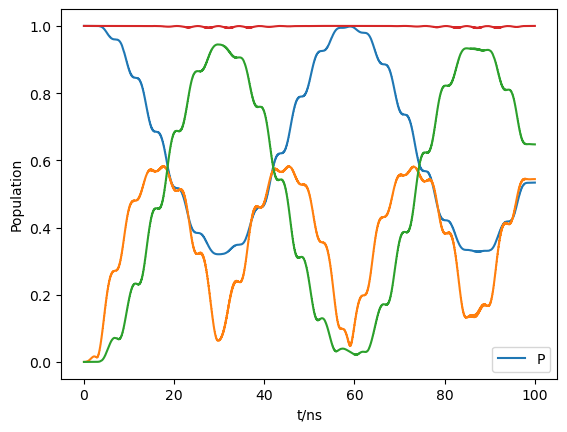

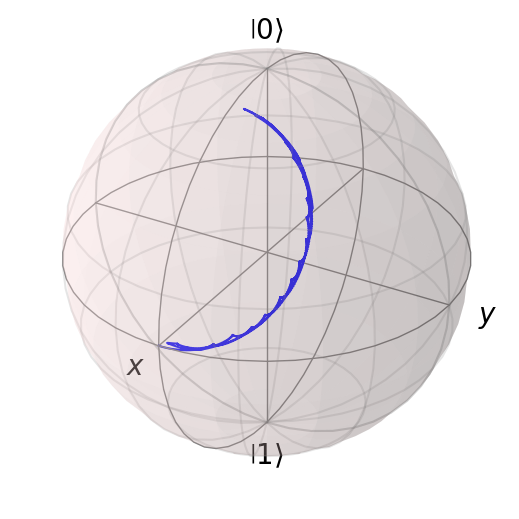

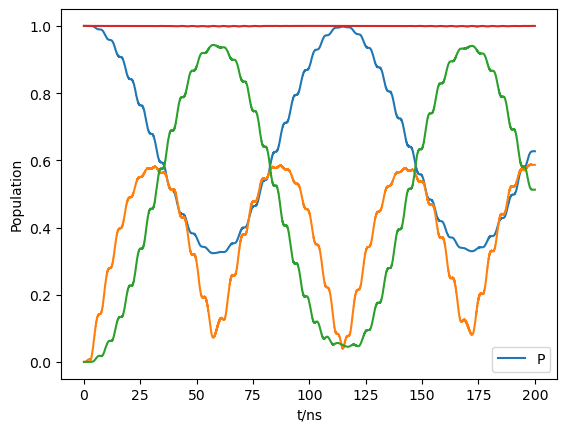

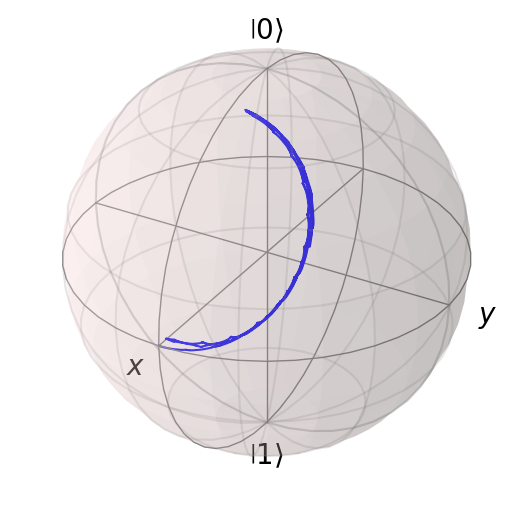

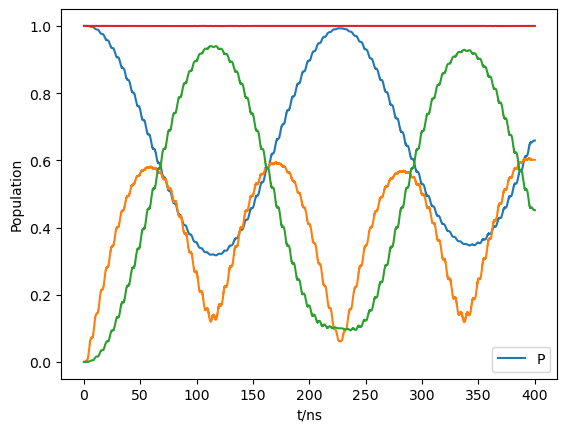

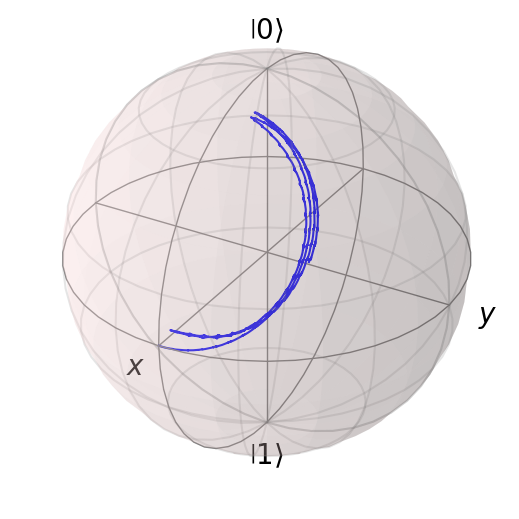

Result object with mesolve data.
--------------------------------
expect = True
num_expect = 3, num_collapse = 0

In [101]:
a=qutrit(w=5,yita=300,TStep=100000,tupdown=5,L=100,\
         rho0=0,rho_tar=2,phid=[0,0],wd=[4.963296, 4.74541],\
            sp=[1,0.5*(1+np.sqrt(3))],amp=0.02,level=4)
a.run(plot=True,issqrt=True)
a.update(amp=0.01,L=200)
a.run(plot=True,issqrt=True)
a.update(amp=0.005,L=400)
a.run(plot=True,issqrt=True)
# 4.74543
# 4.7456608095709765
# a.update(wd=[4.9636131076691825,4.74546],ideal=True)
# print(a.run(plot=True,issqrt=True).expect[2][-1])
# 4.74538-4.74546
# b=a.scan_wd(4.963111,4.963666,10,sp=0,plot=False)

In [43]:
1/330

0.0030303030303030303

(<Figure size 800x400 with 2 Axes>,
 array([<Axes: xlabel='Fock number', ylabel='Occupation probability'>,
        <Axes: title={'center': 'Wigner function'}, xlabel='$\\rm{Re}(\\alpha)$', ylabel='$\\rm{Im}(\\alpha)$'>],
       dtype=object))

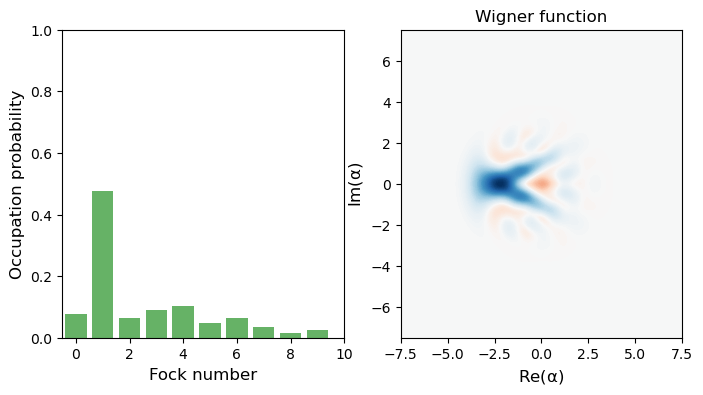

In [35]:
from qutip import *
import numpy as np
s=coherent_dm(10,20*np.pi)
# plot_fock_distribution(fs)
plot_wigner_fock_distribution(s)
# plot_wigner_fock_distribution(rho_mix)
# tracedist(fs,rho_mix)
# plot_
# plot_

In [14]:
import numpy as np
t1=(np.pi-np.arcsin(np.sqrt((3+np.sqrt(3))/3)))/np.pi/2
t1

C:\Users\1163080609\AppData\Local\Temp\ipykernel_16996\3468235532.py:2: RuntimeWarning: invalid value encountered in arcsin
  t1=(np.pi-np.arcsin(np.sqrt((3+np.sqrt(3))/3)))/np.pi/2


nan

In [ ]:
cost=[(np.abs(i-j)+np.abs(j-k)+np.abs(k-i)) for i,j,k in 
    zip(res.expect[0],res.expect[1]res.expect[2])]

In [5]:
import copy as cp
a=[2,3]
b=[0,0]
b[0]=cp.copy(a[0])
b[0]=1
print(a,b)


[2, 3] [1, 0]


In [12]:
c={}
def f(*arg,**para):
    print(arg)
    print(para)
    c.update({'a':2})
    print(c)

d={'a':1}
f()

()
{}
{'a': 2}


In [ ]:
sp=1
[3.9642095125045653, 3.781839726208169]
[3.9593269358577157, 3.785064425698995]

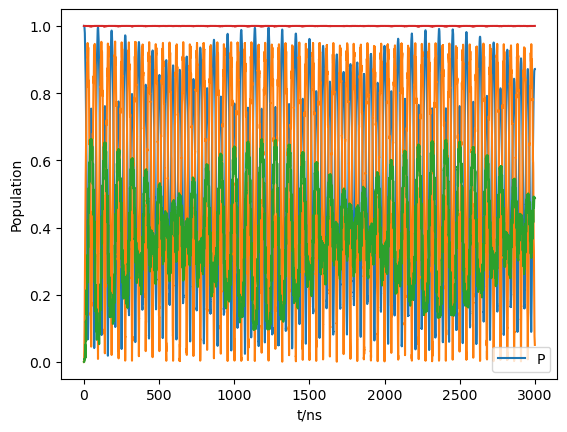

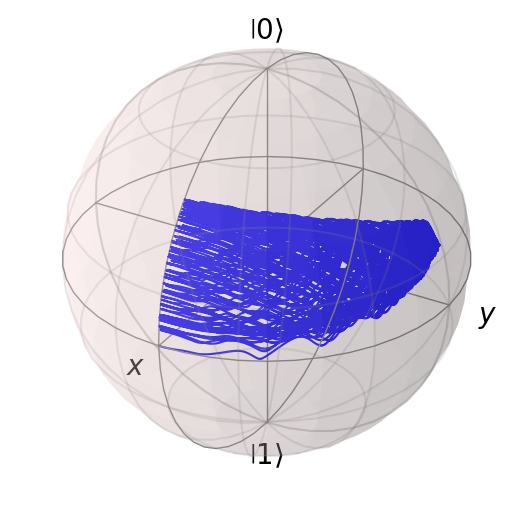

0.4871919741396111


In [95]:
a=qutrit(w=5,yita=300,TStep=100000,tupdown=5,L=3000,\
         rho0=0,rho_tar=2,phid=[0,0],wd=[4.963296, 4.74541],\
            sp=[1,0.5*(1-np.sqrt(3))],amp=0.02,level=4)
print(a.run(plot=True,issqrt=True).expect[2][-1])
# 4.74543
# 4.7456608095709765
# a.update(wd=[4.9636131076691825,4.74546],ideal=True)
# print(a.run(plot=True,issqrt=True).expect[2][-1])
# 4.74538-4.74546
# b=a.scan_wd(4.963111,4.963666,10,sp=0,plot=False)

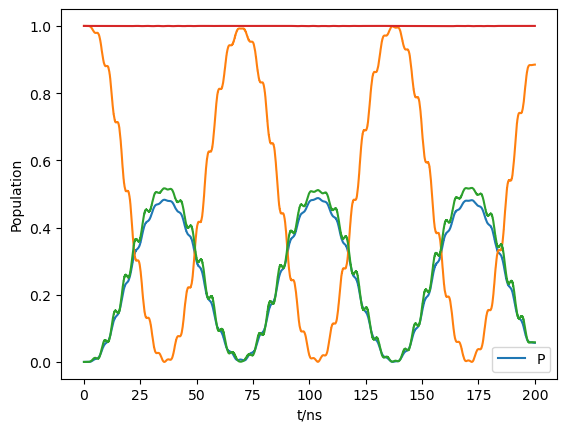

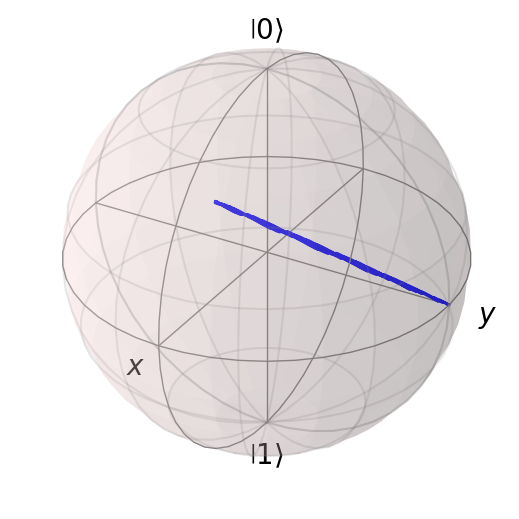

0.058372496940826225


In [17]:
# wd=[4.963296, 4.74541]
# wd=[4.963296, 4.64541]
wd=[4.963296, 4.74541]

a=qutrit(w=5,yita=300,TStep=10000,tupdown=5,L=200,\
         rho0=1,rho_tar=2,phid=[np.pi,1],wd=wd,\
            sp=[1,1],amp=0.01,level=4)
print(a.run(plot=True,issqrt=False).expect[2][-1])
# 4.74543
# 4.7456608095709765
# a.update(wd=[4.9636131076691825,4.74546],ideal=True)
# print(a.run(plot=True,issqrt=True).expect[2][-1])
# 4.74538-4.74546
# b=a.scan_wd(4.963111,4.963666,10,sp=0,plot=False)

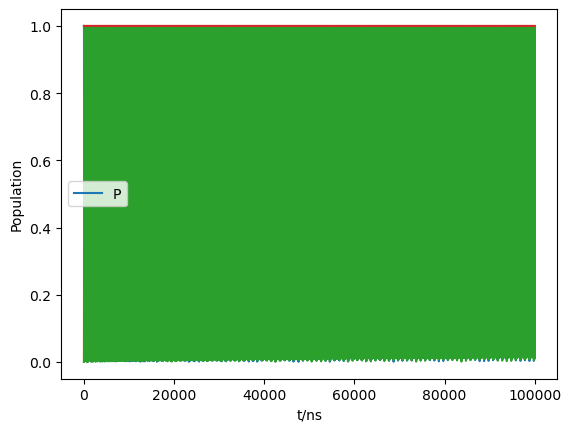

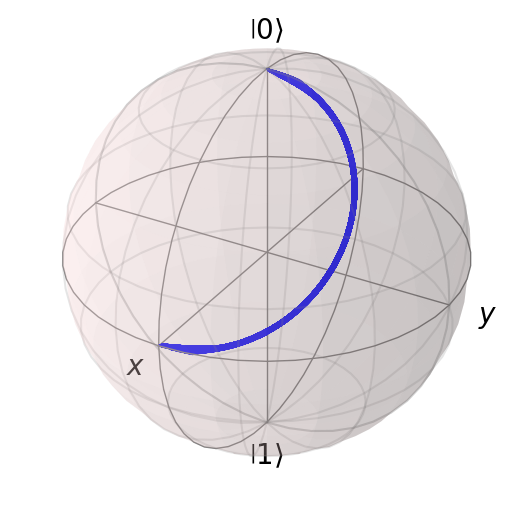

0.04978308385539058


In [6]:
a=qutrit(w=5,yita=300,TStep=10000,tupdown=5,L=100000,\
         rho0=0,rho_tar=2,phid=[np.pi,1],wd=[4.9636131076691825,4.74541],\
            sp=[1,1],amp=0.01,level=4,ideal=True)
print(a.run(plot=True,issqrt=True).expect[2][-1])
# 4.74543
# 4.7456608095709765
# a.update(wd=[4.9636131076691825,4.74546],ideal=True)
# print(a.run(plot=True,issqrt=True).expect[2][-1])
# 4.74538-4.74546
# b=a.scan_wd(4.7454063,4.7454126,10,sp=1,plot=False)

In [6]:
b=[[0,0,0],[1]*3,[2]*3,[3]*3,[4]*3]
[b[x][0:2] for x in [0,1] ]#[0:1]

[[0, 0], [1, 1]]

In [8]:
import numpy as np
np.average([0,1,3])

1.3333333333333333

In [17]:
F2=0.852/4
c=[(1+np.sqrt(1-4*F2))/(2*np.sqrt(F2)),(1-np.sqrt(1-4*F2))/(2*np.sqrt(F2))]
print(c)

[1.5001624960758275, 0.6665944540113697]


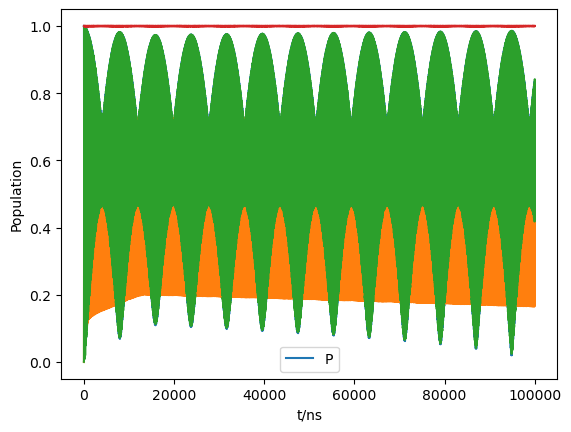

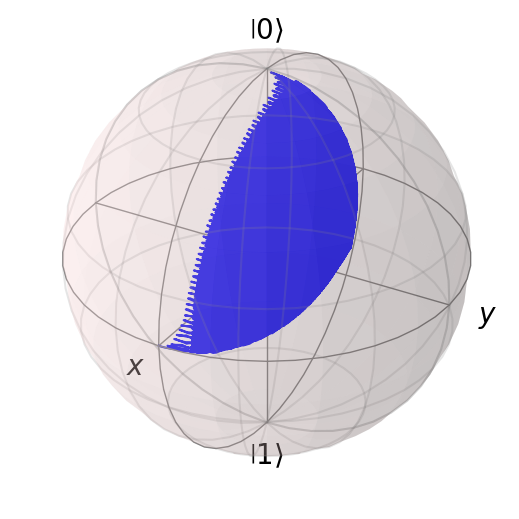

0.7070137121291045


In [5]:
a=qutrit(w=5,yita=300,TStep=100000,tupdown=5,L=100000,\
         rho0=0,rho_tar=2,phid=[np.pi,1],wd=[4.9636131076691825,4.74541],\
            sp=[1,1],amp=0.01,level=4)
print(a.run(plot=True,issqrt=True).expect[2][-1])
# 4.74543
# 4.7456608095709765
# a.update(wd=[4.9636131076691825,4.74546],ideal=True)
# print(a.run(plot=True,issqrt=True).expect[2][-1])
# 4.74538-4.74546
# b=a.scan_wd(4.7454063,4.7454126,10,sp=1,plot=False)

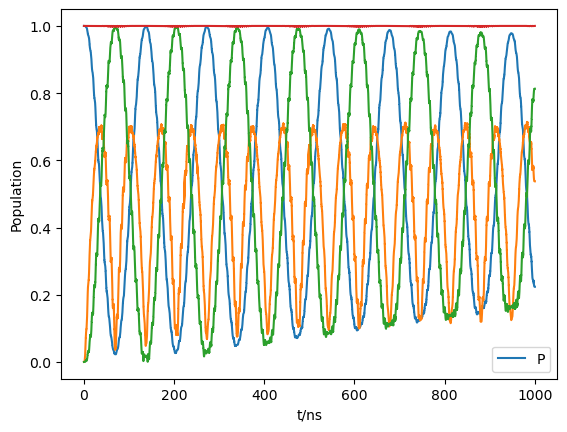

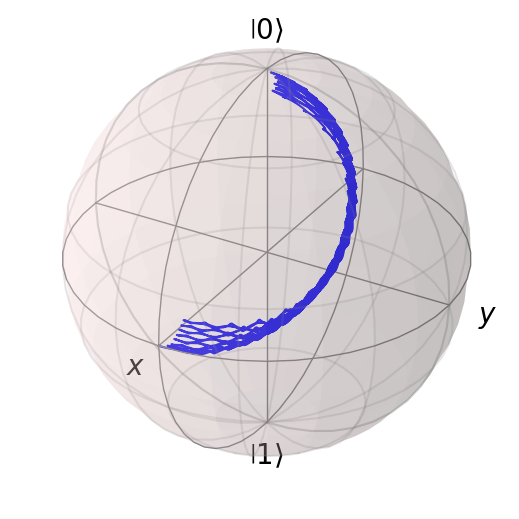

0.8131586124489202


In [12]:
a=qutrit(w=5,yita=300,TStep=100000,tupdown=5,L=1000,\
         rho0=0,rho_tar=2,phid=[np.pi,1],wd=[4.9636131076691825,4.74541],\
            sp=[1,1],amp=0.01,level=4)
print(a.run(plot=True,issqrt=True).expect[2][-1])
# 4.74543
# 4.7456608095709765
# a.update(wd=[4.9636131076691825,4.74546],ideal=True)
# print(a.run(plot=True,issqrt=True).expect[2][-1])
# 4.74538-4.74546
# b=a.scan_wd(4.7454063,4.7454126,10,sp=1,plot=False)

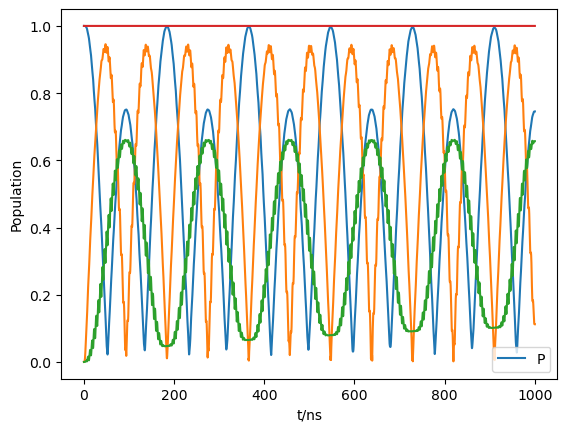

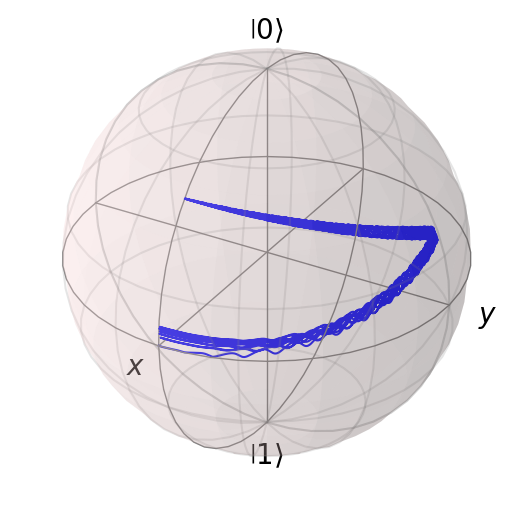

0.6569655896156896


-7.999999999963592e-05

In [ ]:

wd=[4.9636131076691825, 4.7454368421052635]
a=qutrit(w=5,yita=300,TStep=10000,tupdown=5,L=1000,\
         rho0=0,rho_tar=2,phid=[np.pi,1],wd=wd,\
            sp=[1,0.5*(np.sqrt(3)-1)],amp=0.01,level=4)
print(a.run(plot=True,issqrt=True).expect[2][-1])

# a.update(wd=[4.9636131076691825,4.74546],ideal=True)
# print(a.run(plot=True,issqrt=True).expect[2][-1])
4.74538-4.74546
# b=a.scan_wd(4.7452,4.7457,20,sp=1,plot=False)


wd=[4.9636131076691825, 4.7454105]


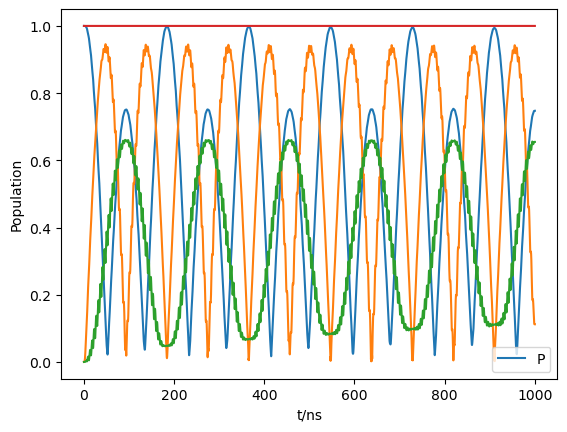

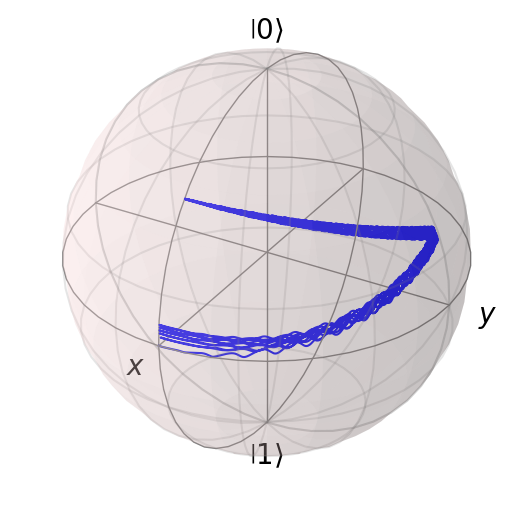

wd=[4.9636131076691825, 4.745416344444445]


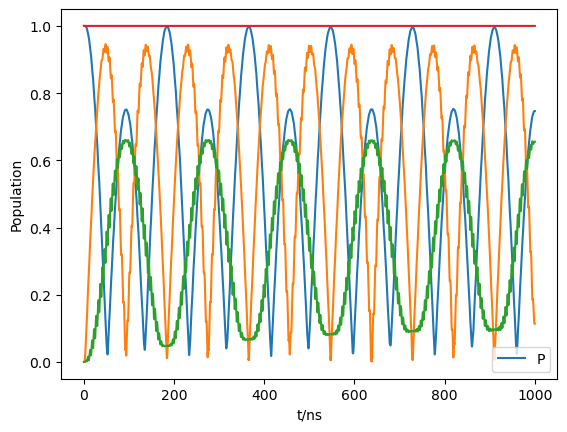

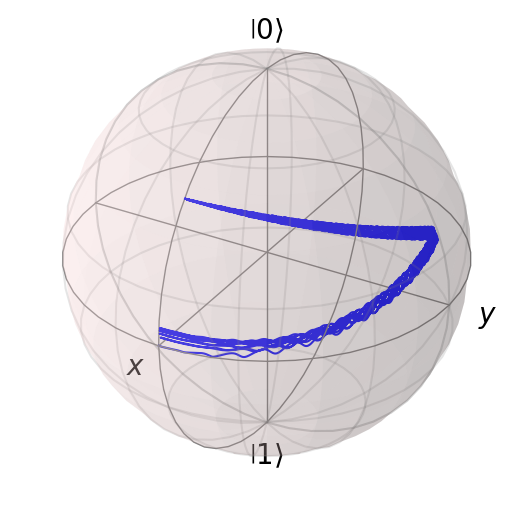

wd=[4.9636131076691825, 4.745422188888889]


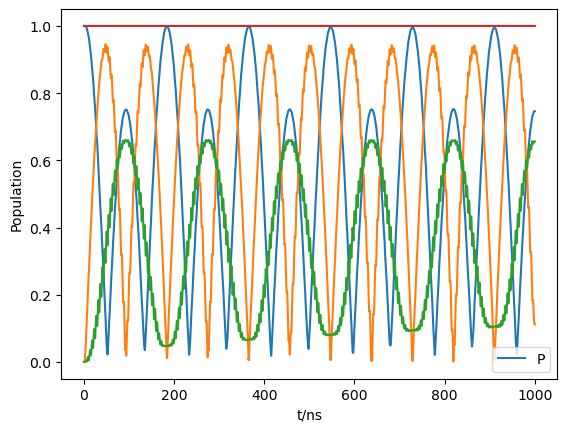

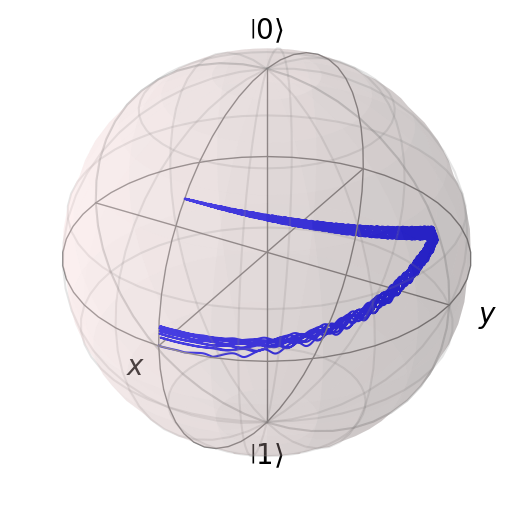

wd=[4.9636131076691825, 4.745428033333334]


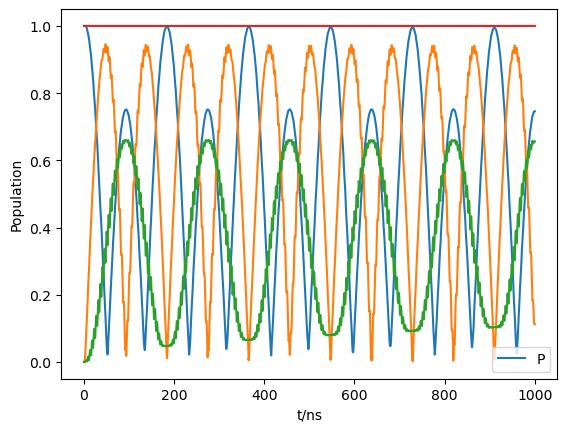

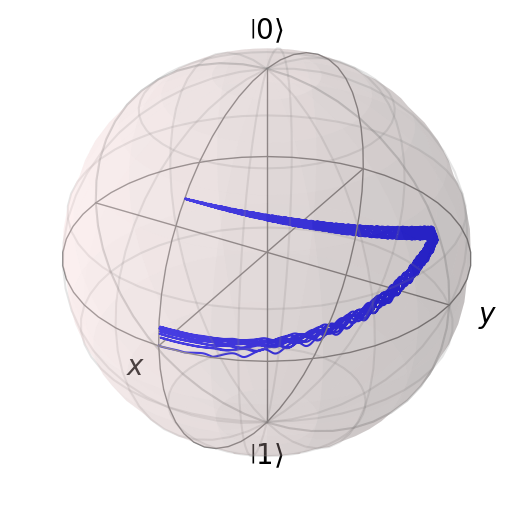

wd=[4.9636131076691825, 4.745433877777778]


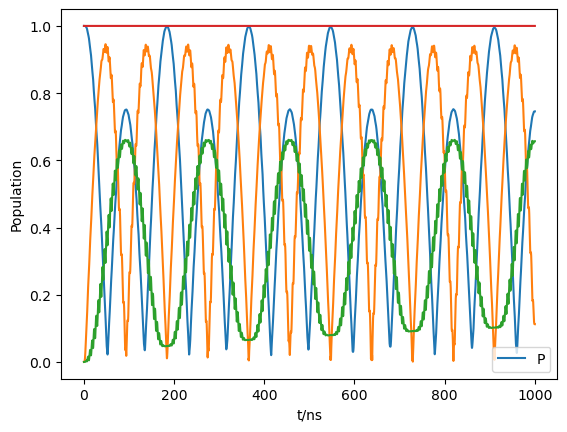

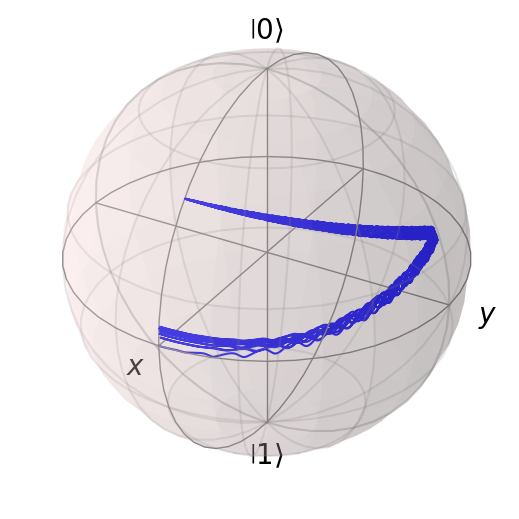

wd=[4.9636131076691825, 4.745439722222223]


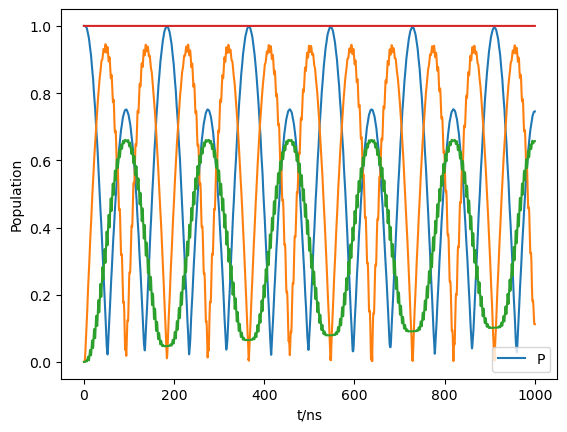

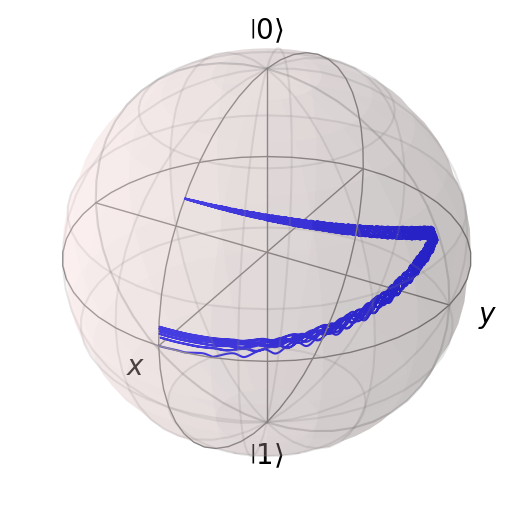

wd=[4.9636131076691825, 4.745445566666667]


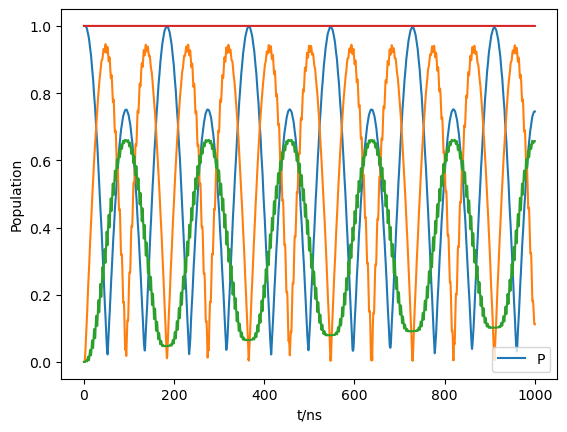

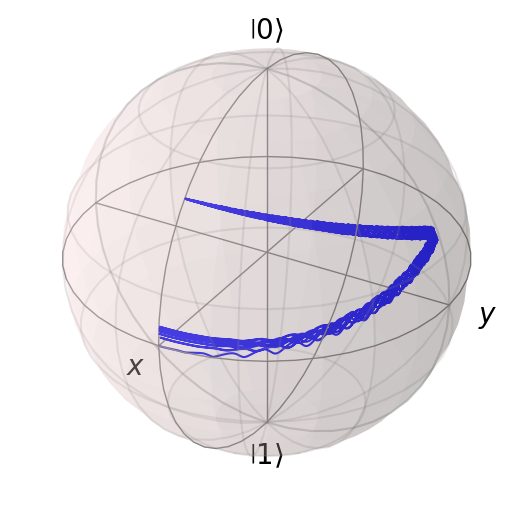

wd=[4.9636131076691825, 4.7454514111111115]


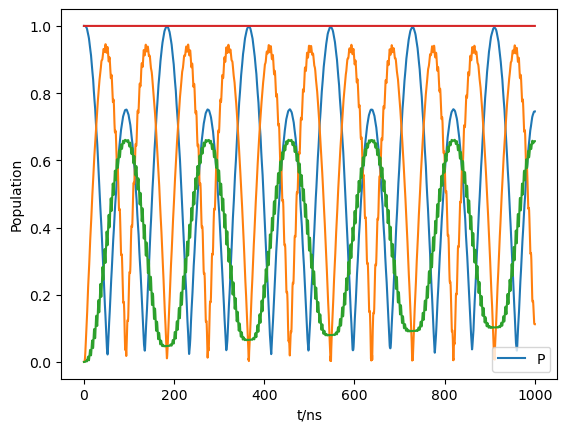

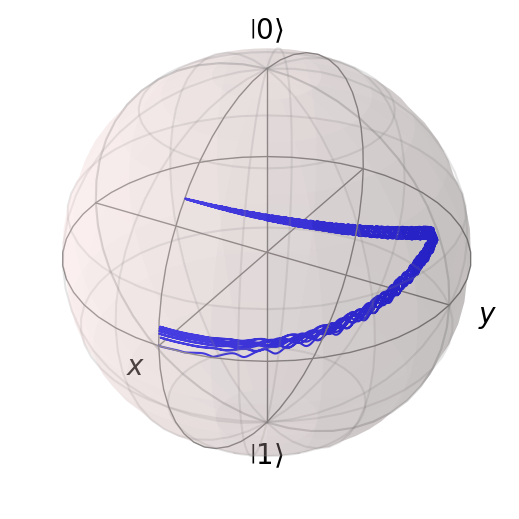

wd=[4.9636131076691825, 4.745457255555555]


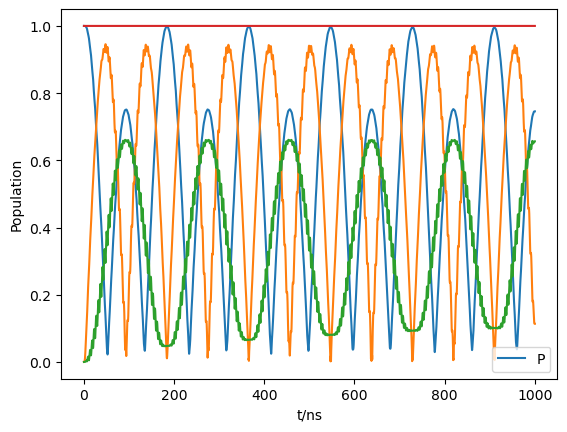

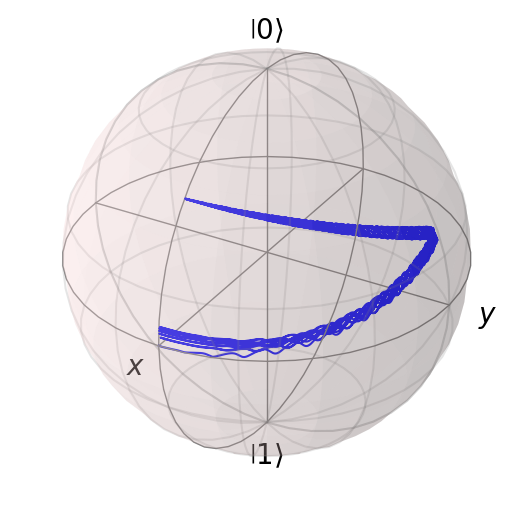

wd=[4.9636131076691825, 4.7454631]


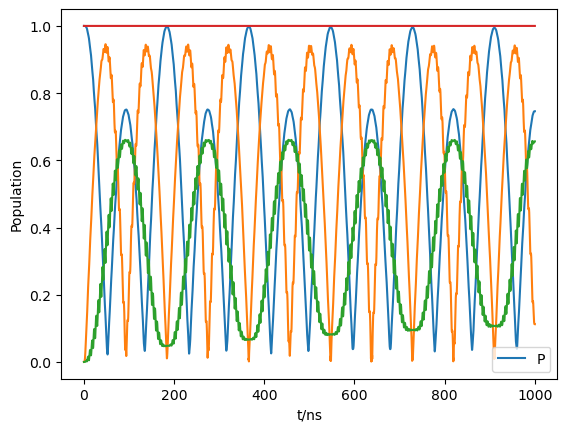

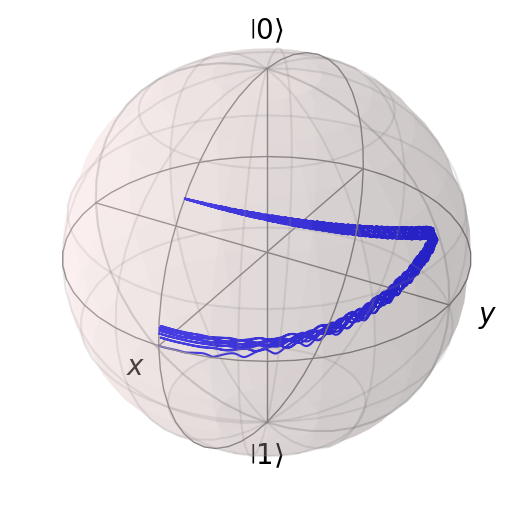

In [87]:
a=qutrit(w=5,yita=300,TStep=10000,tupdown=5,L=1000,\
         rho0=0,rho_tar=2,phid=[np.pi,1],wd=[4.9636131076691825,4.7456608095709765],\
            sp=[1,0.5*(np.sqrt(3)-1)],amp=0.010,level=4)
# print(a.run(plot=True,issqrt=True).expect[2][-1])

# a.update(wd=[4.9636131076691825,4.74546],ideal=True)
# print(a.run(plot=True,issqrt=True).expect[2][-1])
4.74538-4.74546
b=a.scan_wd(4.7454105,4.7454631,10,sp=1,plot=False)


# a.update(ideal=True)
# a.run(plot=True,issqrt=True)


In [ ]:
a=qutrit(w=5,yita=300,TStep=10000,tupdown=5,L=4000,\
         rho0=1,rho_tar=2,phid=[np.pi,1],wd=[4.9636131076691825,4.7456608095709765],\
            sp=[0,1],amp=0.01,level=4,ideal=True)
# print(a.ee)
# print(a.ee[2]-a.ee[1])
a.run(plot=True,issqrt=True)

a.update(ideal=False)
a.run(plot=True,issqrt=True)
# a.sp
a.Drive

In [ ]:
a=qutrit(w=5,yita=300,TStep=10000,tupdown=5,L=400,\
         rho0=0,rho_tar=2,phid=[np.pi,1],wd=[4.9636131076691825,4.7456608095709765],\
            sp=[1,1],amp=0.01,level=4)#,ideal=True)
# print(a.ee)
# print(a.ee[2]-a.ee[1])
a.run(plot=True,issqrt=True)
# a.proj[0]
# a.Drive